<a href="https://colab.research.google.com/github/EthanW67/Machine-Learning-Research/blob/main/Research_Projects/Regular_U_Net_6_19_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 6.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchmetrics.image import StructuralSimilarityIndexMeasure, PeakSignalNoiseRatio
# Load the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts image to PyTorch tensor and scales to [0, 1]
    transforms.Normalize((0.5,), (0.5,))  # Normalize to mean=0.5, std=0.5
])

train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# DataLoader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

ModuleNotFoundError: No module named 'torchmetrics'

In [ ]:
psnr = PeakSignalNoiseRatio()
psnr.to(device)
ssim = StructuralSimilarityIndexMeasure(data_range=1.0)
ssim.to(device)

StructuralSimilarityIndexMeasure()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class u_net(nn.Module):
    def __init__(self, dropout_rate = 0.5):
        super(u_net, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.dropout1 = nn.Dropout2d(p=dropout_rate)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.dropout2 = nn.Dropout2d(p=dropout_rate)

        # Bottleneck
        self.bottleneck = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bottleneck2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv5 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.dropout3 = nn.Dropout2d(p=dropout_rate)

        self.upconv2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv7 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.dropout4 = nn.Dropout2d(p=dropout_rate)

        # Output Layer
        self.outconv = nn.Conv2d(32, 1, kernel_size=3, padding=1)

        # ReLU Layer
        self.relu = nn.ReLU()

    def forward(self, x):
        # Encode
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.dropout1(x)
        skip_connection1 = x
        x = self.pool(x)

        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.dropout2(x)
        skip_connection2 = x
        x = self.pool(x)

        # Bottleneck
        x = self.relu(self.bottleneck(x))
        x = self.relu(self.bottleneck2(x))
        # Decoder
        x = self.upconv1(x)
        x = self.relu(self.conv5(torch.cat((skip_connection2, x), 1))) # Concatenate after upsampling
        x = self.relu(self.conv6(x))
        x = self.dropout3(x)

        x = self.upconv2(x)
        x = self.relu(self.conv7(torch.cat((skip_connection1, x), 1))) # Concatenate after upsampling
        x = self.relu(self.conv8(x))
        x = self.dropout4(x)

        # Output Layer
        x = self.outconv(x)
        return x

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = u_net().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


epoch_numbers = []
psnr_values = []
ssim_values = []

# Define a function to train the model
def train(model, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, _ in train_loader:
            # Move tensors to the appropriate device
            images = images.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(images)
            loss = criterion(outputs, images)  # Using the original images as both input and target
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch {epoch+1}: Loss {running_loss / len(train_loader)}')

        PSNR_value, SSIM_value = PSNR_SSIM_Value(model, test_loader)

        epoch_numbers.append(epoch + 1)
        psnr_values.append(PSNR_value)
        ssim_values.append(SSIM_value)

# Train the model
#train(model, criterion, optimizer, num_epochs = 2)


In [ ]:
import matplotlib.pyplot as plt

def validate(model, loader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    criterion = nn.MSELoss()
    with torch.no_grad():  # No need to track gradients
        for images, _ in loader:
            images = images.to(device)
            high_res_images = images.to(device)

            outputs = model(images)
            loss = criterion(outputs, high_res_images)
            total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    print(f'Validation Loss: {avg_loss}')
    return avg_loss

def visualize_results(model, loader):
    model.eval()
    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device)

            print(images.shape)
            outputs = model(images)
            print(outputs.shape)

            # Convert first 4 images in the batch from PyTorch tensors to NumPy arrays
            input_images = images[:4].cpu().numpy()
            reconstructed_images = outputs[:4].cpu().numpy()
            # original_images = images[:4].numpy()

            PSNR_value = psnr(outputs, images)

            print(PSNR_value)
            SSIM_value = ssim(outputs, images)

            print(SSIM_value)

            # Plotting
            fig, axes = plt.subplots(2, 4, figsize=(12, 9))
            for i in range(4):
                # Display original images
                ax = axes[0][i]
                ax.imshow(input_images[i].reshape(28, 28), cmap='gray', interpolation = 'none')
                ax.title.set_text('Original')
                ax.axis('off')

                # Display reconstructed images
                ax = axes[1][i]
                ax.imshow(reconstructed_images[i].reshape(28, 28), cmap='gray', interpolation = 'none')
                ax.title.set_text('Reconstructed')
                ax.axis('off')

            plt.show()
            break  # Only show one batch of images
    return  PSNR_value.item(), SSIM_value.item()

epoch = 10
def PSNR_SSIM_Value(model, loader):
    model.eval()
    with torch.inference_mode():
        for images, _ in loader:
            images = images.to(device)
            #print(images.shape)
            outputs = model(images)
            #print(outputs.shape)
            PSNR_value = psnr(outputs, images)
            SSIM_value = ssim(outputs, images)
            break
    if epoch % 2 == 0:
      print(PSNR_value)
      print(SSIM_value)
    return  PSNR_value.item(), SSIM_value.item()

In [ ]:
# Train the model
train(model, criterion, optimizer, num_epochs=50)

# Validate the model
avg_loss = validate(model, test_loader)
psnr_value, ssim_value = PSNR_SSIM_Value(model, test_loader)


# Plot the epoch numbers vs. PSNR and SSIM
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epoch_numbers, psnr_values, label='PSNR')
print(epoch_numbers)
print(psnr_values)
plt.xlabel('Epoch Number')
plt.ylabel('PSNR')
plt.title('Epoch Number vs. PSNR')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epoch_numbers, ssim_values, label='SSIM')
print(ssim_values)
plt.xlabel('Epoch Number')
plt.ylabel('SSIM')
plt.title('Epoch Number vs. SSIM')
plt.grid(True)

plt.show()


Epoch 1: Loss 0.05759876990702742
tensor(30.2989, device='cuda:0')
tensor(0.8739, device='cuda:0')
Epoch 2: Loss 0.00026916996220471525
tensor(45.7126, device='cuda:0')
tensor(0.9975, device='cuda:0')
Epoch 3: Loss 8.377429787136579e-05
tensor(48.2526, device='cuda:0')
tensor(0.9988, device='cuda:0')
Epoch 4: Loss 5.323347326346747e-05
tensor(49.9937, device='cuda:0')
tensor(0.9991, device='cuda:0')
Epoch 5: Loss 5.7242648727512476e-05
tensor(50.7061, device='cuda:0')
tensor(0.9991, device='cuda:0')
Epoch 6: Loss 5.496568333670082e-05
tensor(51.2283, device='cuda:0')
tensor(0.9981, device='cuda:0')
Epoch 7: Loss 5.3585135000074646e-05
tensor(51.1546, device='cuda:0')
tensor(0.9968, device='cuda:0')
Epoch 8: Loss 4.8147539662649365e-05
tensor(53.1386, device='cuda:0')
tensor(0.9997, device='cuda:0')
Epoch 9: Loss 0.00032938521252305435
tensor(49.3394, device='cuda:0')
tensor(0.9990, device='cuda:0')
Epoch 10: Loss 3.286516433468459e-05
tensor(52.4574, device='cuda:0')
tensor(0.9995, dev

Epoch 1: Loss 0.00013884774770457118
tensor(48.5584, device='cuda:0')
tensor(0.9960, device='cuda:0')
Epoch 2: Loss 0.00011775357940265023
tensor(50.1523, device='cuda:0')
tensor(0.9989, device='cuda:0')
Validation Loss: 3.947770926008775e-05
tensor(50.1523, device='cuda:0')
tensor(0.9989, device='cuda:0')


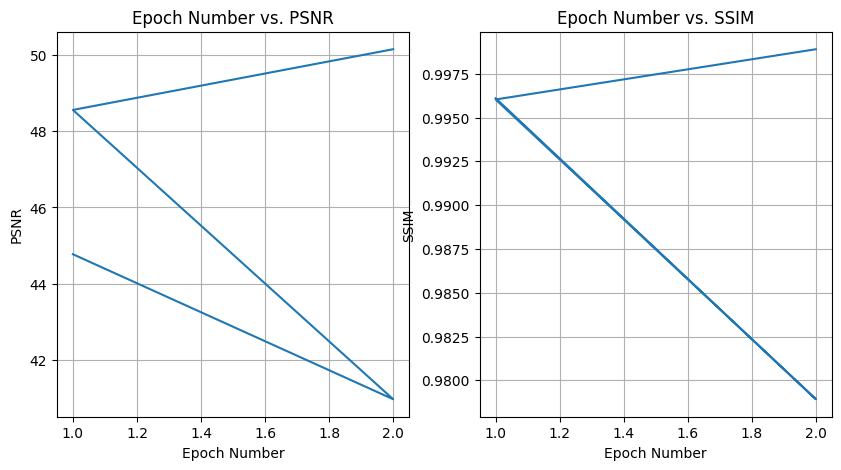

In [ ]:
# Initialize lists to store epoch numbers, PSNR values, and SSIM values
"""
epoch_numbers = []
psnr_values = []
ssim_values = []
"""

# Train the model for a number of epochs

# Train the model
train(model, criterion, optimizer, num_epochs = 2)

# Validate the model
avg_loss = validate(model, test_loader)

# Visualize the results
psnr_value, ssim_value = PSNR_SSIM_Value(model, test_loader)

# Store the epoch number, PSNR, and SSIM values
#epoch_numbers.append(epoch + 1)
"""
print(epoch_numbers)
psnr_values.append(psnr_value)
print(psnr_values)
ssim_values.append(ssim_value)
print(ssim_values)
"""
# Plot the epoch numbers vs. PSNR and SSIM
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epoch_numbers, psnr_values, label='PSNR')
plt.xlabel('Epoch Number')
plt.ylabel('PSNR')
plt.title('Epoch Number vs. PSNR')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epoch_numbers, ssim_values, label='SSIM')
plt.xlabel('Epoch Number')
plt.ylabel('SSIM')
plt.title('Epoch Number vs. SSIM')
plt.grid(True)

plt.show()
